In [5]:
import os
import numpy as np
import pandas as pd
import time
from pathlib import Path

!pip install silence_tensorflow
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

import tensorflow as tf
import multiprocessing
cores = multiprocessing.cpu_count() # Count the number of cores in a computer
tf.config.threading.set_intra_op_parallelism_threads(cores)
tf.config.threading.set_inter_op_parallelism_threads(cores)
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, MaxPooling2D, Conv2D, SeparableConv2D
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras import layers
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
### Download dataset from kagglehub
import kagglehub

# Download latest version
path = kagglehub.dataset_download("fanconic/skin-cancer-malignant-vs-benign")

print("Path to dataset files:", path)

100%|██████████| 325M/325M [00:14<00:00, 23.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/fanconic/skin-cancer-malignant-vs-benign/versions/4


In [8]:
train_dir = path + '/train/'
test_dir = path + '/test/'

(224, 224)

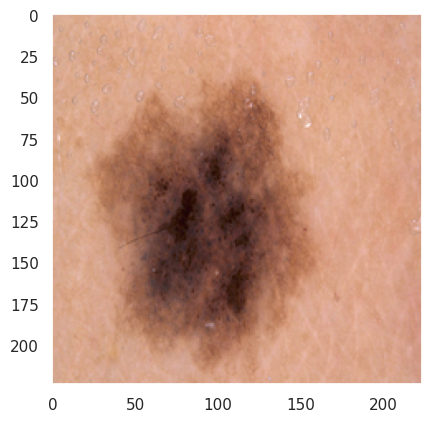

In [ ]:
## Visualize a random image in benign dir
import os
random_number = np.random.randint(1000)

train_figure_name = os.listdir(train_dir + 'benign')[random_number]
full_name_train = train_dir + 'benign' + '/' + train_figure_name
image = load_img(full_name_train)
#display(image)
plt.imshow(image)
plt.grid(False)
image.size

In [9]:
#Genenrate image data sets for training, validation and test
image_size = (224, 224)
batch_size = 32

data_train = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

data_test = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255
)

train_generator = data_train.flow_from_directory(
    train_dir,
    target_size=image_size,
    class_mode='binary',
    batch_size=batch_size,
    subset='training'
)

validation_generator = data_train.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

test_generator = data_test.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

Found 2110 images belonging to 2 classes.
Found 527 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [ ]:
### Check size of each batch
for train_data_batch, train_label_batch in train_generator:
    print("Train data batch shape:", train_data_batch.shape)
    print("Train label batch shape:", train_label_batch.shape)
    break

for val_data_batch, val_label_batch in validation_generator:
    print("Validation data batch shape:", val_data_batch.shape)
    print("Validation label batch shape:", val_label_batch.shape)
    break

for test_data_batch, test_label_batch in test_generator:
    print("Test data batch shape:", test_data_batch.shape)
    print("Test label batch shape:", test_label_batch.shape)
    break



Train data batch shape: (32, 224, 224, 3)
Train label batch shape: (32,)
Validation data batch shape: (32, 224, 224, 3)
Validation label batch shape: (32,)
Test data batch shape: (32, 224, 224, 3)
Test label batch shape: (32,)


In [ ]:
train_label_batch

array([0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0.],
      dtype=float32)

In [ ]:
### classess of images in the data set
train_generator.class_indices

{'benign': 0, 'malignant': 1}

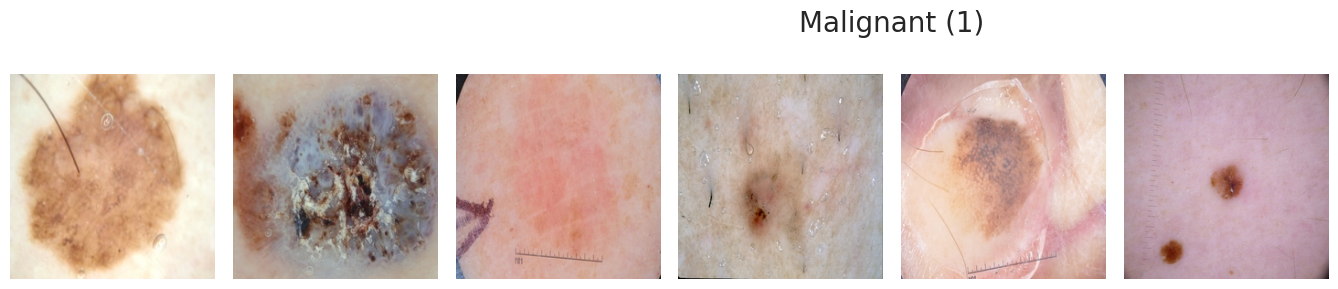

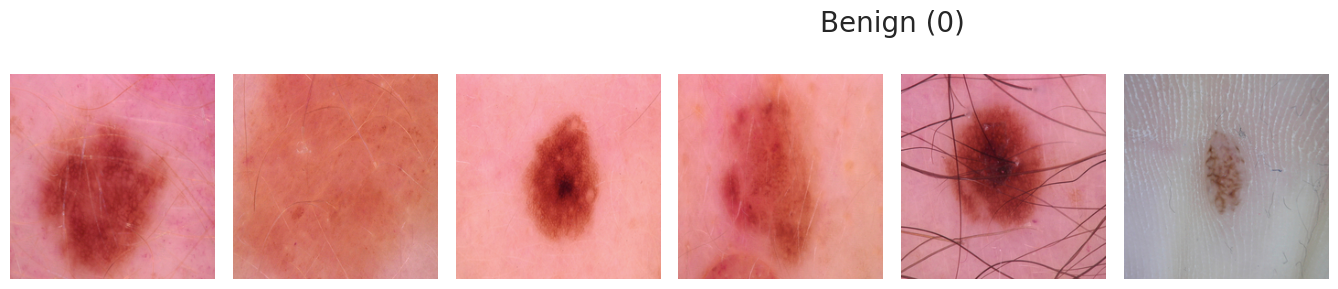

In [ ]:
### Show some images in each class of the data set
for images, labels in train_generator:
    malignant = [{'image': image, 'label': label} for image, label in zip(images, labels) if label == 1]
    benign = [{'image': image, 'label': label} for image, label in zip(images, labels) if label == 0]
    break

### first 6 images of each label
image_set = [malignant[:6], benign[:6]]

for image_label in image_set:
    plt.figure(figsize=(18,3))
    plt.suptitle('Malignant (1)' if int(image_label[0]['label'])==1 else 'Benign (0)', fontsize=20)

    for image in range(len(image_label)):
        plt.subplot(1, 8, image+1)
        plt.imshow(image_label[image]['image'])
        plt.axis('off')
    plt.tight_layout()


Text(0.5, 1.0, 'Test set')

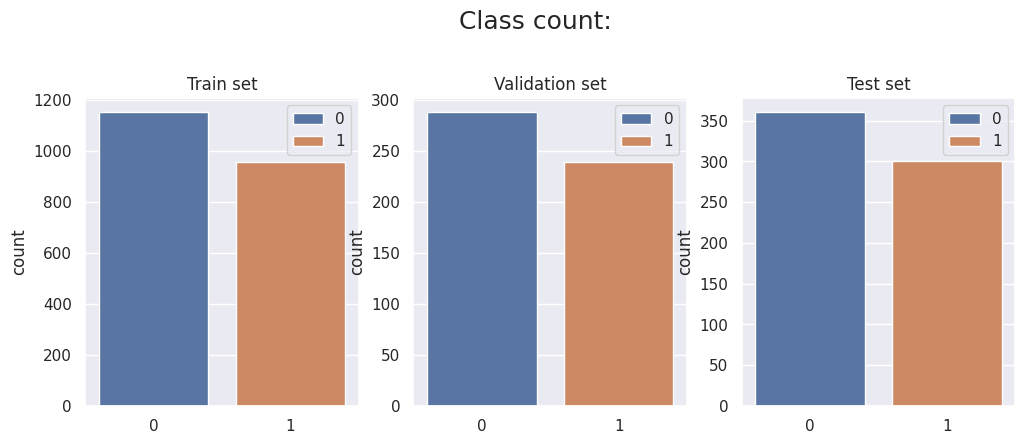

In [ ]:
plt.figure(figsize=(12,4))
plt.suptitle('Class count:', fontsize=18, y=1.1)

#train set
plt.subplot(1,3,1)
sns.countplot(x=train_generator.classes, hue=train_generator.classes)
plt.title('Train set')

#validation set
plt.subplot(1,3,2)
sns.countplot(x=validation_generator.classes, hue=validation_generator.classes)
plt.title('Validation set')

#test set
plt.subplot(1,3,3)
sns.countplot(x=test_generator.classes, hue=test_generator.classes)
plt.title('Test set')


In [ ]:
## distribution of classes in training, validataion, and test sets
train_generator.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [10]:
for gen, name in zip([train_generator, validation_generator, test_generator],
                     ['train', 'validation', 'test']):
    count_malignant = (gen.classes==1).sum()
    count_benign = (gen.classes==0).sum()
    tot = len(gen.classes)
    print(f"Class distribution in the {name} set")
    print(f"Benign: {count_benign/tot:.0%}")
    print(f"Malignant: {count_malignant/tot:.0%}\n")

Class distribution in the train set
Benign: 55%
Malignant: 45%

Class distribution in the validation set
Benign: 55%
Malignant: 45%

Class distribution in the test set
Benign: 55%
Malignant: 45%



In [11]:
#### Define metrics

model_metrics = [
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.FalseNegatives(name='fn'),
]

output_bias = -np.log(count_malignant/count_benign)
print('Initial output bias:', output_bias)
output_bias = tf.keras.initializers.Constant(output_bias)

input_bias = -np.log(1/2)
print('Initiali output bias:', input_bias)
input_bias = tf.keras.initializers.Constant(input_bias)



Initial output bias: 0.1823215567939546
Initiali output bias: 0.6931471805599453


In [12]:
### callback function
model_dir = '/content/drive/MyDrive/Deep_Learning/Skin_cancer/models'
os.makedirs(model_dir, exist_ok=True)
csv_dir = '/content/drive/MyDrive/Deep_Learning/Skin_cancer/logs'
os.makedirs(csv_dir, exist_ok=True)

def callbacks(model_name, append_csv=False):
  callb = [
      tf.keras.callbacks.ModelCheckpoint(
          filepath = model_dir + '/' + model_name + '.keras',
          monitor='val_auc',
          save_best_only=True,
          mode='max'
      ),
      tf.keras.callbacks.EarlyStopping(
          monitor='val_auc',
          patience=10,
          mode='max',
          restore_best_weights=True
      ),
      tf.keras.callbacks.CSVLogger(
          filename=csv_dir + '/' + model_name + '.csv',
          separator=',',
          append=append_csv
      )
  ]
  return callb

In [ ]:
## model construction frame
def model_frame(dropout=0.0):
  input_tensor = keras.Input(shape=(224,224,3), name='input')

  hidden_Conv2Dlayer = SeparableConv2D(filters=32, kernel_size=(3,3), activation='relu', name='hidden_layer_1')(input_tensor)
  maxpooling2D_layer = MaxPooling2D(pool_size=(2,2))(hidden_Conv2Dlayer)

  hidden_Conv2Dlayer = SeparableConv2D(filters=64, kernel_size=(3,3), activation='relu', name='hidden_layer_2')(maxpooling2D_layer)
  maxpooling2D_layer = MaxPooling2D(pool_size=(2,2))(hidden_Conv2Dlayer)

  hidden_Conv2Dlayer = SeparableConv2D(filters=128, kernel_size=(3,3), activation='relu', name='hidden_layer_3')(maxpooling2D_layer)
  maxpooling2D_layer = MaxPooling2D(pool_size=(2,2))(hidden_Conv2Dlayer)

  hidden_Conv2Dlayer = SeparableConv2D(filters=256, kernel_size=(3,3), activation='relu', name='hidden_layer_4')(maxpooling2D_layer)
  maxpooling2D_layer = MaxPooling2D(pool_size=(2,2))(hidden_Conv2Dlayer)

  hidden_ave2DPooling  = keras.layers.GlobalAveragePooling2D(name='hidden_ave2DPooling')(maxpooling2D_layer)

  if dropout:
    hidden_ave2DPooling = layers.Dropout(dropout, name='hidden_dropout')(hidden_ave2DPooling)

  hidden_dense = layers.Dense(16, activation='relu', name='hidden_dense', kernel_initializer='he_normal')(hidden_ave2DPooling)

  out_put = layers.Dense(1, activation='sigmoid', name='output', bias_initializer=output_bias)(hidden_dense)

  model = keras.Model(inputs=input_tensor, outputs=out_put)
  return model

In [ ]:
### model construction

model = model_frame()
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(),metrics=model_metrics)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden_layer_1 (SeparableConv2D)     │ (None, 222, 222, 32)        │             155 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden_layer_2 (SeparableConv2D)     │ (None, 109, 109, 64)        │           2,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden_layer_3 (SeparableConv2D)     │ (None, 52, 52, 128)         │           8,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden_layer_4 (SeparableConv2D)     │ (None, 24, 24, 256)         │          34,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden_ave2DPooling                  │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden_dense (Dense)                 │ (None, 16)                  │           4,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,756 (194.36 KB)

 Trainable params: 49,756 (194.36 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
### train the model
%%time
model_name = 'my_model'
history = model.fit(train_generator,
                    epochs=100,
                    callbacks=callbacks(model_name),
                    validation_data=validation_generator)

Epoch 1/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.8335 - auc: 0.9231 - fn: 71.9104 - fp: 103.1045 - loss: 0.3346 - precision: 0.8007 - recall: 0.8538 - tn: 486.8507 - tp: 424.3731 - val_accuracy: 0.8008 - val_auc: 0.8636 - val_fn: 50.0000 - val_fp: 55.0000 - val_loss: 0.4828 - val_precision: 0.7746 - val_recall: 0.7908 - val_tn: 233.0000 - val_tp: 189.0000
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - accuracy: 0.8443 - auc: 0.9326 - fn: 63.6269 - fp: 105.1194 - loss: 0.3152 - precision: 0.8015 - recall: 0.8692 - tn: 484.8955 - tp: 432.0000 - val_accuracy: 0.7837 - val_auc: 0.8639 - val_fn: 73.0000 - val_fp: 41.0000 - val_loss: 0.5333 - val_precision: 0.8019 - val_recall: 0.6946 - val_tn: 247.0000 - val_tp: 166.0000
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - accuracy: 0.8443 - auc: 0.9276 - fn: 66.0000 - fp: 102.8060 - loss: 0.3316 - precision: 0.8083 - recall: 0.8662 - tn: 491.6119 - tp: 426.8358 - val_accuracy: 0.8159 - val_auc: 0.8791 - val_fn

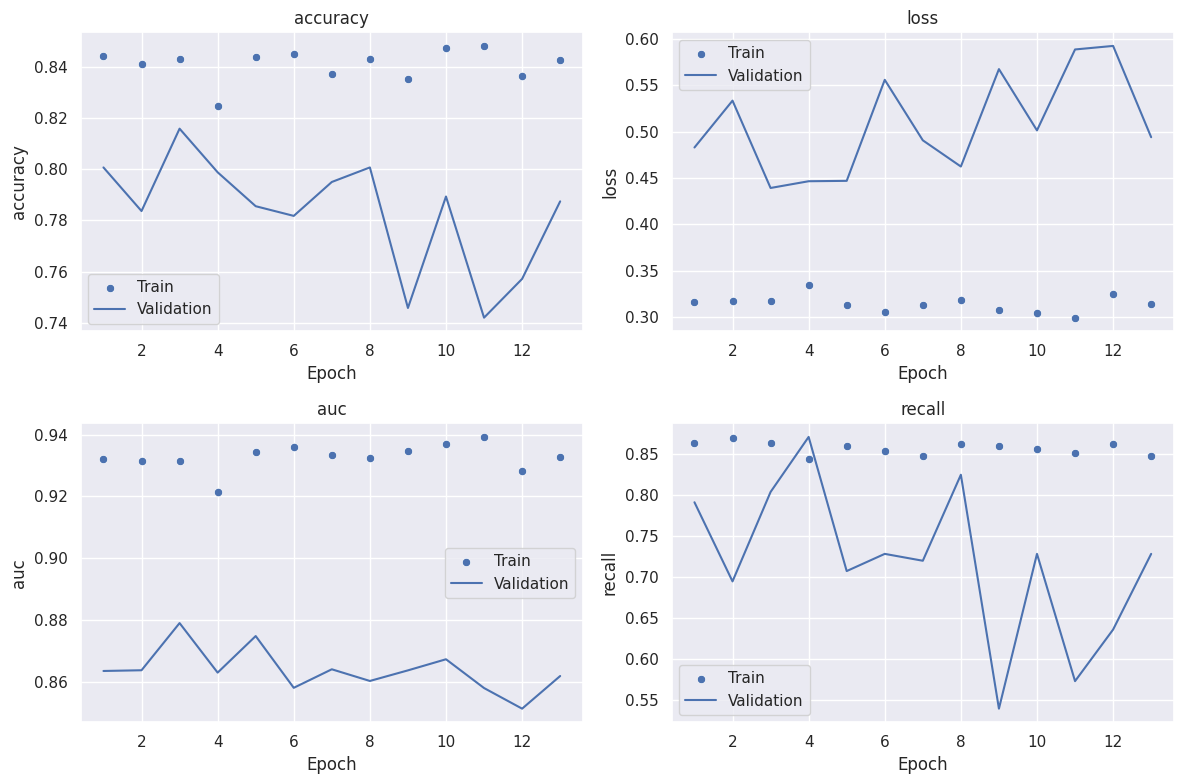

In [ ]:
def plot_training_history(metrics, hist_dict):
  epochs = range(1, len(hist_dict[metrics])+1)
  sns.scatterplot(x=epochs, y=hist_dict[metrics])
  sns.lineplot(x=epochs,y= hist_dict['val_'+metrics])
  plt.title(metrics)
  plt.xlabel('Epoch')
  plt.ylabel(metrics)
  plt.legend(['Train', 'Validation'])


plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plot_training_history('accuracy', history.history)

plt.subplot(2,2,2)
plot_training_history('loss', history.history)

plt.subplot(2,2,3)
plot_training_history('auc', history.history)

plt.subplot(2,2,4)
plot_training_history('recall', history.history)

plt.tight_layout()


In [ ]:
model_name = 'my_model'
train_model = keras.models.load_model(model_dir + '/' + model_name + '.keras')
test_results = train_model.evaluate(test_generator)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.8353 - auc: 0.9127 - fn: 24.4091 - fp: 35.4545 - loss: 0.3641 - precision: 0.8018 - recall: 0.8533 - tn: 163.9545 - tp: 141.6364


In [ ]:
test_results

[0.3456765115261078,
 0.8633333444595337,
 0.9234490394592285,
 0.8068535923957825,
 0.8439394235610962,
 259.0,
 298.0,
 62.0,
 41.0]

In [ ]:
## Generate prediction values from the trained model, and extracl
prediction_testset = []
label_testset = []
num_batch = len(test_generator)
i = 0
for data, label in test_generator:
  prediction_testset.extend(train_model.predict(data).flatten())
  label_testset.extend(label)
  i +=1
  if i >= num_batch:
    prediction_testset = np.array(prediction_testset)
    label_testset = np.array(label_testset)
    break


len(prediction_testset) == len(label_testset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


True

In [ ]:
prediction_testset[:10] > 0.5

array([False,  True, False, False, False, False,  True, False, False,
        True])

In [ ]:
confusion_matrix = tf.math.confusion_matrix(labels=label_testset, predictions=prediction_testset>0.5)
confusion_matrix

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[305,  59],
       [ 44, 252]], dtype=int32)>

Text(46.25, 0.5, 'True class')

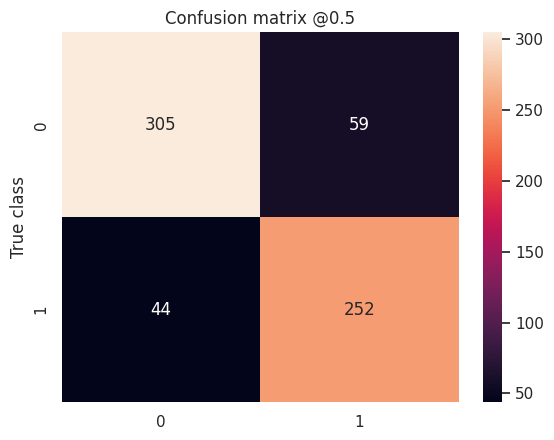

In [ ]:
### plot confustion matrix
sns.heatmap(confusion_matrix, annot=True, fmt='d')
plt.title('Confusion matrix @0.5')
plt.ylabel('True class')

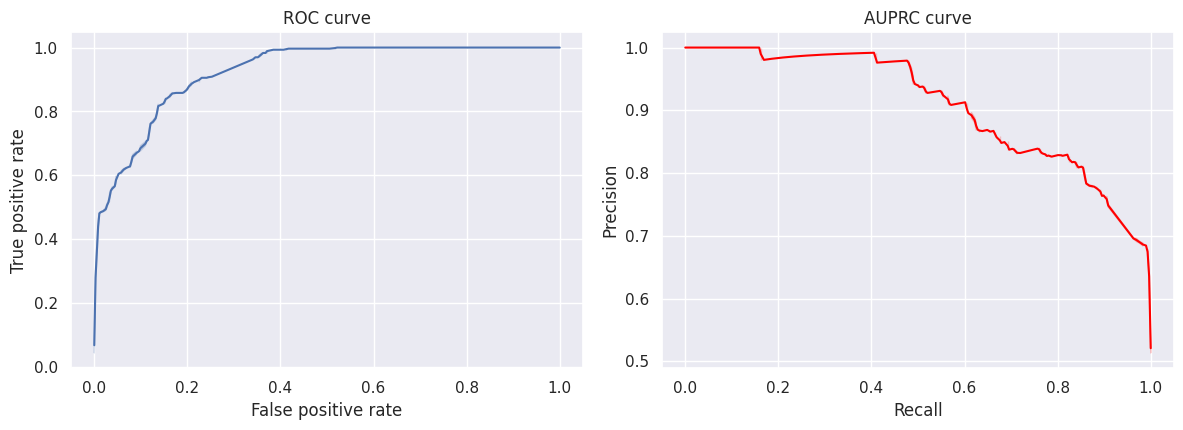

In [ ]:
#Plot the ROC and AUPRC
def plot_roc_curve()


fpr, tpr, thresholds_roc = metrics.roc_curve(label_testset, prediction_testset)
precision, recall, thresholds_prc = metrics.precision_recall_curve(label_testset, prediction_testset)


plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
sns.lineplot(x=fpr, y=tpr)
plt.title('ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.grid(True)

plt.subplot(2,2,2)
sns.lineplot(x=recall, y = precision, color='red')
plt.title('AUPRC curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)

plt.tight_layout()

In [ ]:
def plot_roc(name, labels, predictions, **kwargs):
    """ Function for plotting the ROC curve. """
    fp, tp, _ = metrics.roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5, 60])
    plt.ylim([20, 100.5])
    plt.grid(True)
    plt.title('ROC', fontsize=16)
    plt.legend(loc='lower right');


def plot_prc(name, labels, predictions, **kwargs):
    """ Function for plotting the area under the interpolated precision-recall curve (AUPRC). """
    precision, recall, _ = metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    plt.title('AUPRC', fontsize=16);

In [ ]:
# Get predictions and labels for the train and validation sets
def get_predictions_and_labels(model, generator):
  prediction_set = []
  label_set = []
  num_batch = len(generator)
  i = 0
  for data, label in generator:
    prediction_set.extend(model.predict(data).flatten())
    label_set.extend(label)
    i +=1
    if i >= num_batch:
      prediction_set = np.array(prediction_set)
      label_set = np.array(label_set)
      break
  return prediction_set, label_set

train_preds_baseline, train_labels_baseline = get_predictions_and_labels(train_model, train_generator)
validation_preds_baseline, validation_labels_baseline = get_predictions_and_labels(train_model, validation_generator)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━

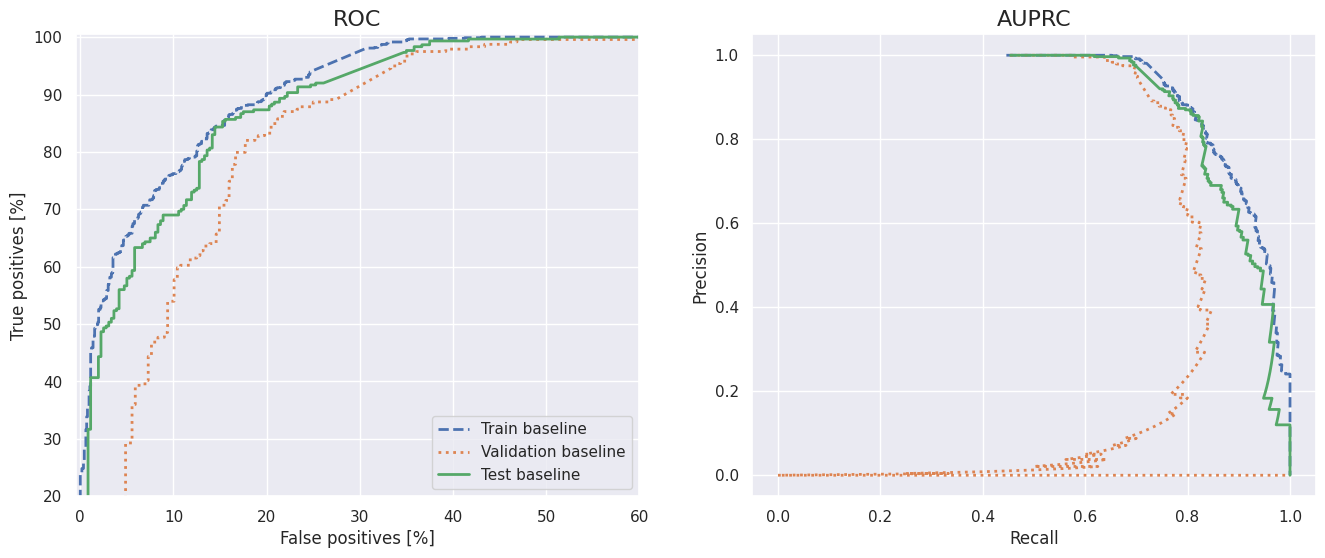

In [ ]:
# Plot the ROC and AUPRC
plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plot_roc('Train baseline', train_labels_baseline, train_preds_baseline, linestyle='--')
plot_roc('Validation baseline', validation_labels_baseline, validation_preds_baseline, linestyle=':')
plot_roc('Test baseline', test_labels, test_preds_baseline);

plt.subplot(1, 2, 2)
plot_prc('Train baseline', train_labels_baseline, train_preds_baseline, linestyle='--')
plot_prc('Validation baseline', validation_labels_baseline, validation_preds_baseline, linestyle=':')
plot_prc('Test baseline', test_labels, test_preds_baseline)

In [ ]:
def train_and_evaluate_model_n_times(n_times, train_gen, valid_gen, test_gen,
                                     name, dropout=0.0, epochs=20):

    histories = []                # Train and validation scores
    test_scores = []              # Test scores

    for i in range(n_times):
        print(f"Training model: {i+1} (out of {n_times} times)...")
        start = time.time()

        # Instantiate a new model
        model = model_frame(dropout)
        # Compile the model
        model.compile(loss='binary_crossentropy',
                      optimizer=keras.optimizers.Adam(),
                      metrics=model_metrics)
        # Train it
        hist = model.fit(train_gen,
                         epochs=epochs,
                         callbacks=callbacks(name),
                         validation_data=valid_gen,
                         verbose=0,
                  )

        # Print out how long it took to train one model
        time_taken = time.gmtime(int(time.time() - start))
        print(f'Time taken: {time.strftime("%Hh %Mmin %Ss", time_taken)} ... Evaluating...')

        # Load the best model and evaluate it on the test set
        best_model = keras.models.load_model(model_dir+'/'+name +'.keras')
        test_score = best_model.evaluate(test_gen, return_dict=True)

        # Store the results
        histories.append(hist.history)
        test_scores.append(test_score)

        # Clear memory by releasing the global state
        tf.keras.backend.clear_session()

    # Save histories and test scores to file
    pd.DataFrame(histories).to_csv(csv_dir+'/'+name+'_histories.csv', index=False)
    pd.DataFrame(test_scores).to_csv(csv_dir+'/'+name+'_scores.csv', index=False)

    return histories, test_scores


def print_model_performance(scores, dset='test'):
    print(f"Average model performance on the {dset} set over {scores.shape[0]} runs:\n")
    for col in scores:
        mean = np.mean(scores[col])
        std = np.std(scores[col])
        print("{:<10} {:<5} (±{:.2f})".format(str(col+':').capitalize(), np.round(mean, 2), std))

In [ ]:
%%time

# Train and evaluate 10 models
histories, test_scores = train_and_evaluate_model_n_times(10,
                                                          train_generator,
                                                          validation_generator,
                                                          test_generator,
                                                          name='base_model_cv')

Training model: 1 (out of 10 times)...
Time taken: 00h 02min 59s ... Evaluating...
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.7930 - auc: 0.8944 - fn: 16.5455 - fp: 58.0909 - loss: 0.3789 - precision: 0.7238 - recall: 0.9024 - tn: 137.6818 - tp: 153.1364
Training model: 2 (out of 10 times)...
Time taken: 00h 03min 13s ... Evaluating...
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.7966 - auc: 0.8974 - fn: 2.8182 - fp: 70.7727 - loss: 0.3932 - precision: 0.6847 - recall: 0.9866 - tn: 131.6364 - tp: 160.2273
Training model: 3 (out of 10 times)...


### Data augmentation

In [ ]:
augmented_dir = Path('/content/drive/MyDrive/Deep_Learning/Skin_cancer/augmented_images')
augmented_train_dir = augmented_dir / 'augmented_train'
augmented_test_dir = augmented_dir / 'augmented_test'

os.makedirs(augmented_train_dir, exist_ok=True)
os.makedirs(augmented_test_dir,exist_ok=True)


In [13]:
#Genenrate image data sets for training, validation and test
image_size = (224, 224)
batch_size = 32

augmented_train_gen = ImageDataGenerator(
    rotation_range=30,
    brightness_range=[0.9,1.1],
    zoom_range=0.1,
    fill_mode='constant',
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1./255,
    validation_split=0.2
)

validation_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_gen = ImageDataGenerator(
    rescale=1./255
)

### training dataset

augmented_train_generator = augmented_train_gen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

augmented_validation_generator = validation_gen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

augmented_test_generator = test_gen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

Found 2110 images belonging to 2 classes.
Found 527 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


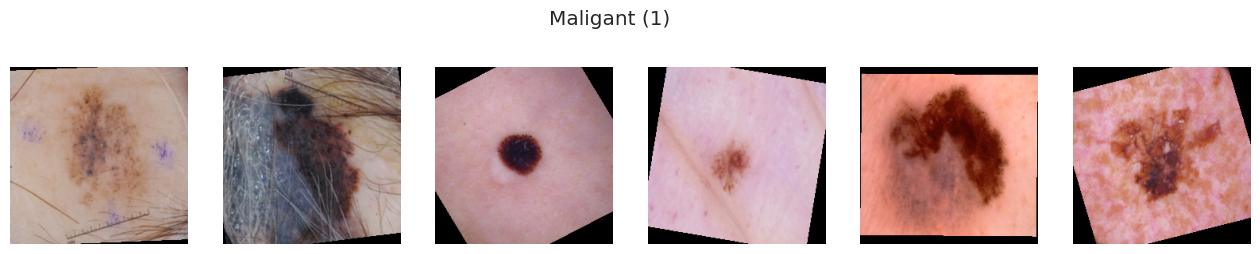

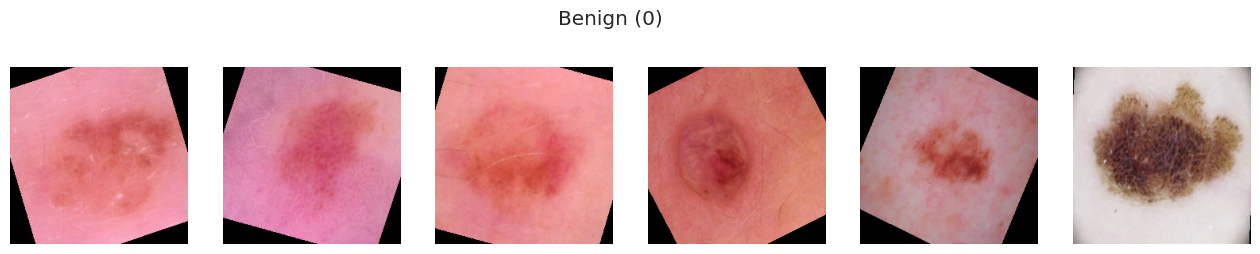

In [14]:
### visualize some images

for images, labels in augmented_train_generator:
    malignant_set = [{'image':image, 'label':label} for image, label in zip(images, labels) if label==1]
    benign_set = [{'image':image, 'label':label} for image, label in zip (images, labels) if label==0]

    break

for image_label in malignant_set[:6], benign_set[:6]:
  plt.figure(figsize=(16,3))
  plt.suptitle('Maligant (1)' if int(image_label[0]['label'])==1 else 'Benign (0)')
  for i in range(int(len(malignant_set[:6]))):
    plt.subplot(1, int(len(malignant_set[:6])), i+1)
    plt.imshow(image_label[i]['image'])
    plt.axis('off')
  plt.show()



### Train the model

In [ ]:
model = model_frame(dropout=0.5)
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=model_metrics)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden_layer_1 (SeparableConv2D)     │ (None, 222, 222, 32)        │             155 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden_layer_2 (SeparableConv2D)     │ (None, 109, 109, 64)        │           2,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden_layer_3 (SeparableConv2D)     │ (None, 52, 52, 128)         │           8,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden_layer_4 (SeparableConv2D)     │ (None, 24, 24, 256)         │          34,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden_ave2DPooling                  │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden_dropout (Dropout)             │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden_dense (Dense)                 │ (None, 16)                  │           4,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,756 (194.36 KB)

 Trainable params: 49,756 (194.36 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(augmented_train_generator,
                    epochs=50,
                    callbacks=callbacks('augmented_model'),
                    validation_data=augmented_validation_generator)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


66/66 ━━━━━━━━━━━━━━━━━━━━ 59s 646ms/step - accuracy: 0.4781 - auc: 0.5118 - fn: 79.7612 - fp: 484.6866 - loss: 0.6989 - precision: 0.4684 - recall: 0.9048 - tn: 102.0000 - tp: 419.8806 - val_accuracy: 0.5465 - val_auc: 0.6309 - val_fn: 239.0000 - val_fp: 0.0000e+00 - val_loss: 0.6890 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 288.0000 - val_tp: 0.0000e+00
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 33s 439ms/step - accuracy: 0.5386 - auc: 0.5300 - fn: 497.5373 - fp: 0.0000e+00 - loss: 0.6898 - precision: 0.2836 - recall: 9.0599e-04 - tn: 588.6418 - tp: 0.7761 - val_accuracy: 0.5465 - val_auc: 0.7843 - val_fn: 239.0000 - val_fp: 0.0000e+00 - val_loss: 0.6829 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 288.0000 - val_tp: 0.0000e+00
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 31s 434ms/step - accuracy: 0.5580 - auc: 0.6660 - fn: 414.0597 - fp: 46.6567 - loss: 0.6668 - precision: 0.5652 - recall: 0.1032 - tn: 545.1194 - tp: 79.8657 - val_accuracy: 0.7249 - val_a

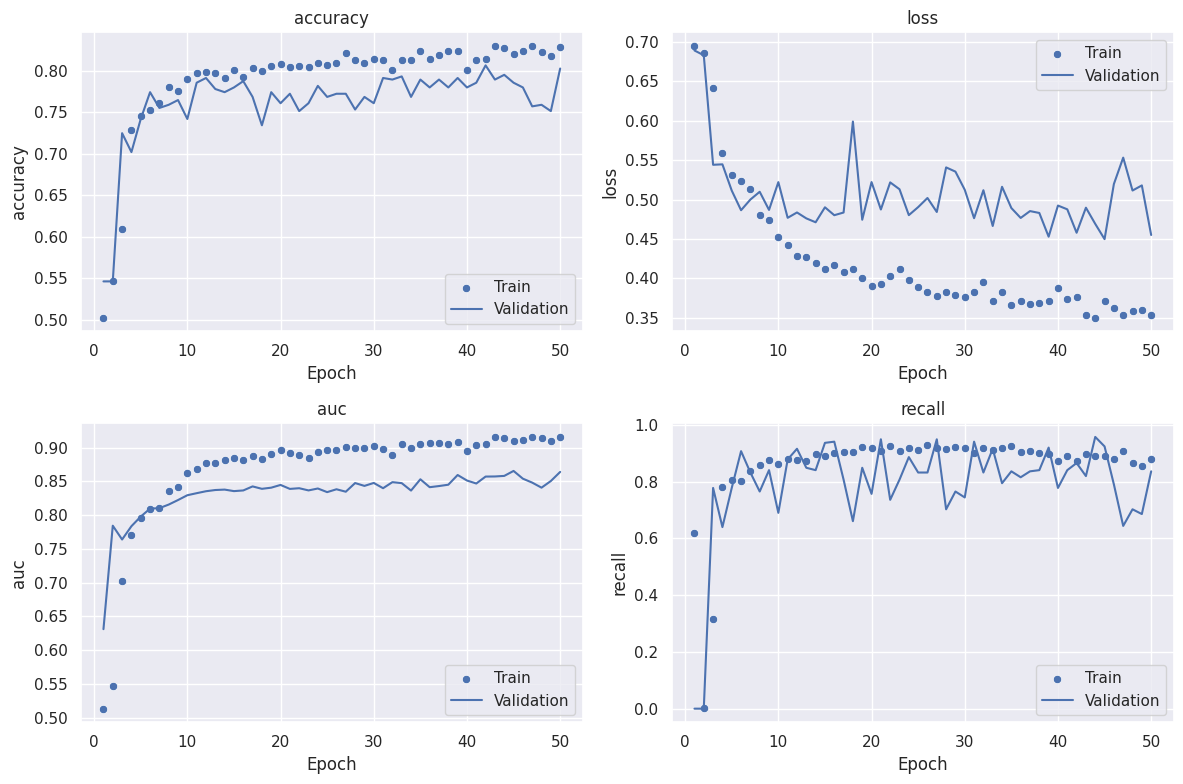

In [ ]:
def plot_training_history(metrics, hist_dict):
  epochs = range(1, len(hist_dict[metrics])+1)
  sns.scatterplot(x=epochs, y=hist_dict[metrics])
  sns.lineplot(x=epochs,y= hist_dict['val_'+metrics])
  plt.title(metrics)
  plt.xlabel('Epoch')
  plt.ylabel(metrics)
  plt.legend(['Train', 'Validation'])


plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plot_training_history('accuracy', history.history)

plt.subplot(2,2,2)
plot_training_history('loss', history.history)

plt.subplot(2,2,3)
plot_training_history('auc', history.history)

plt.subplot(2,2,4)
plot_training_history('recall', history.history)

plt.tight_layout()

In [ ]:
## Generate prediction values from the trained model, and extracl
augmented_model = keras.models.load_model(model_dir + '/' + 'augmented_model' + '.keras')
test_results = augmented_model.evaluate(augmented_test_generator)

prediction_testset = []
label_testset = []
num_batch = len(augmented_test_generator)
i = 0
for data, label in augmented_test_generator:
  prediction_testset.extend(augmented_model.predict(data).flatten())
  label_testset.extend(label)
  i +=1
  if i >= num_batch:
    augmented_prediction_testset = np.array(prediction_testset)
    augmented_label_testset = np.array(label_testset)
    break


len(augmented_prediction_testset) == len(augmented_label_testset)

21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.8030 - auc: 0.9084 - fn: 4.3636 - fp: 68.9091 - loss: 0.3809 - precision: 0.7220 - recall: 0.9718 - tn: 123.2273 - tp: 168.9545
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


True

In [ ]:
confusion_matrix = tf.math.confusion_matrix(labels=augmented_label_testset, predictions=augmented_prediction_testset>0.5)
confusion_matrix

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[245, 114],
       [ 10, 291]], dtype=int32)>

Text(46.25, 0.5, 'True class')

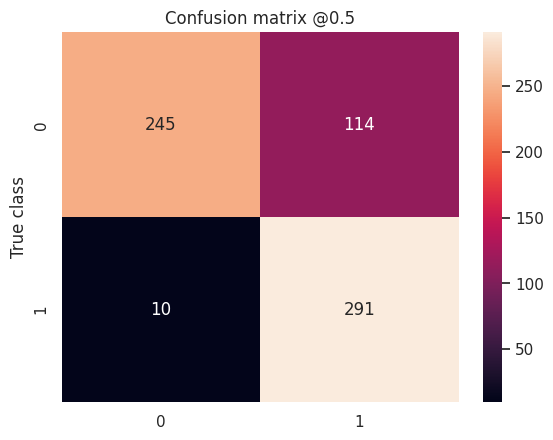

In [ ]:
### plot confustion matrix
sns.heatmap(confusion_matrix, annot=True, fmt='d')
plt.title('Confusion matrix @0.5')
plt.ylabel('True class')

In [ ]:
train_preds_augmented, train_labels_aug = get_predictions_and_labels(augmented_model, augmented_train_generator)
validation_preds_augmented, validation_labels_aug = get_predictions_and_labels(augmented_model, augmented_validation_generator)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━

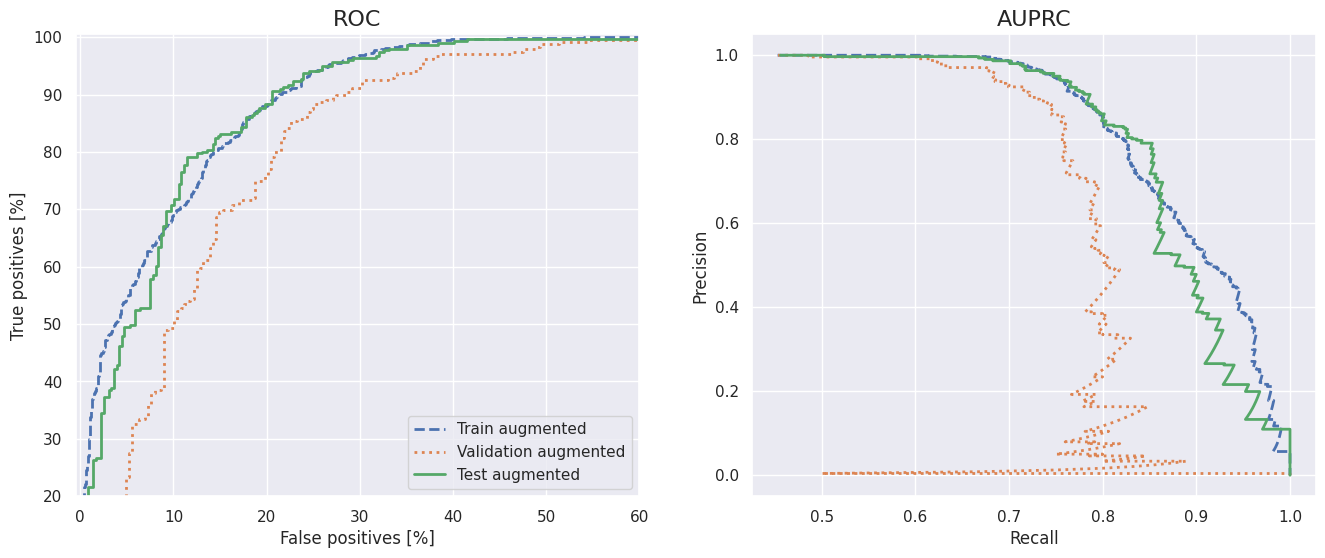

In [ ]:

plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plot_roc('Train augmented', train_labels_aug, train_preds_augmented, linestyle='--')
plot_roc('Validation augmented', validation_labels_aug, validation_preds_augmented, linestyle=':')
plot_roc('Test augmented', augmented_label_testset, augmented_prediction_testset)

plt.subplot(1, 2, 2)
plot_prc('Train augmented', train_labels_aug, train_preds_augmented, linestyle='--')
plot_prc('Validation augmented', validation_labels_aug, validation_preds_augmented, linestyle=':')
plot_prc('Test augmented', augmented_label_testset, augmented_prediction_testset);

###Transfer Learning: Pre-trained Xception model

In [15]:
pre_trained_Xception = keras.applications.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(None,None,3)
)

pre_trained_Xception.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None, None, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, None, None, 32) │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, None, None, 32) │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, None, None, 32) │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, None, None, 64) │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, None, None, 64) │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, None, None, 64) │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, None, None,     │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, None, None,     │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, None, None,     │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, None, None,     │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, None, None,     │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, None, None,     │          8,192 │ block1_conv2_act[0][0] │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, None, None,     │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │ 128)                   │                │                        │
├──────────────────────

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [ ]:
image_size=(224,224)
input_tensor = keras.Input(shape=(image_size+(3,)))
x = pre_trained_Xception(input_tensor)
x = keras.layers.Flatten()(x) ## Dense layers need a 2D input
x = keras.layers.Dense(16, activation='relu', kernel_initializer='he_normal')(x)
output = keras.layers.Dense(1, activation='sigmoid', name='output', bias_initializer=output_bias)(x)

Xception_model = keras.Model(inputs=input_tensor, outputs=output, name='Xception_model')

Xception_model.summary()




Model: "Xception_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xception (Functional)                │ (None, 7, 7, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │       1,605,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,467,145 (85.71 MB)

 Trainable params: 22,412,617 (85.50 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [ ]:
### Freeze the pre_trained_Xception model
#for layers in pre_trained_Xception.layers:
#  layers.trainable = False

print("Number of trainable parameters BEFORE freezing the conv base:", len(Xception_model.trainable_weights))

# Freeze the conv base
pre_trained_Xception.trainable = False
print("Number of trainable parameters AFTER freezing the conv base:", len(Xception_model.trainable_weights))



Number of trainable parameters BEFORE freezing the conv base: 158
Number of trainable parameters AFTER freezing the conv base: 4


In [ ]:
Xception_model.compile(loss='binary_crossentropy',
                       optimizer=keras.optimizers.Adam(learning_rate=2e-5),
                       metrics=model_metrics)

Xception_model.summary()

Model: "Xception_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xception (Functional)                │ (None, 7, 7, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │       1,605,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,467,145 (85.71 MB)

 Trainable params: 1,605,665 (6.13 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [ ]:
## Train the model
Xception_model_history = Xception_model.fit(augmented_train_generator,
                                            validation_data=augmented_validation_generator,
                                            epochs=100,
                                            callbacks=callbacks('Xception_model')
                                            )

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


66/66 ━━━━━━━━━━━━━━━━━━━━ 78s 882ms/step - accuracy: 0.6718 - auc: 0.7330 - fn: 198.7612 - fp: 127.4925 - loss: 0.5978 - precision: 0.6495 - recall: 0.5522 - tn: 472.2686 - tp: 288.7314 - val_accuracy: 0.6433 - val_auc: 0.7516 - val_fn: 181.0000 - val_fp: 7.0000 - val_loss: 0.6459 - val_precision: 0.8923 - val_recall: 0.2427 - val_tn: 281.0000 - val_tp: 58.0000
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 36s 504ms/step - accuracy: 0.8030 - auc: 0.8874 - fn: 119.1791 - fp: 96.0149 - loss: 0.4332 - precision: 0.8117 - recall: 0.7423 - tn: 497.4776 - tp: 374.5224 - val_accuracy: 0.7078 - val_auc: 0.8004 - val_fn: 137.0000 - val_fp: 17.0000 - val_loss: 0.5716 - val_precision: 0.8571 - val_recall: 0.4268 - val_tn: 271.0000 - val_tp: 102.0000
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 36s 493ms/step - accuracy: 0.8257 - auc: 0.9091 - fn: 100.1194 - fp: 90.2836 - loss: 0.3927 - precision: 0.8253 - recall: 0.8048 - tn: 491.9105 - tp: 403.4478 - val_accuracy: 0.7590 - val_auc: 0.8346 - val_fn: 91.0000 

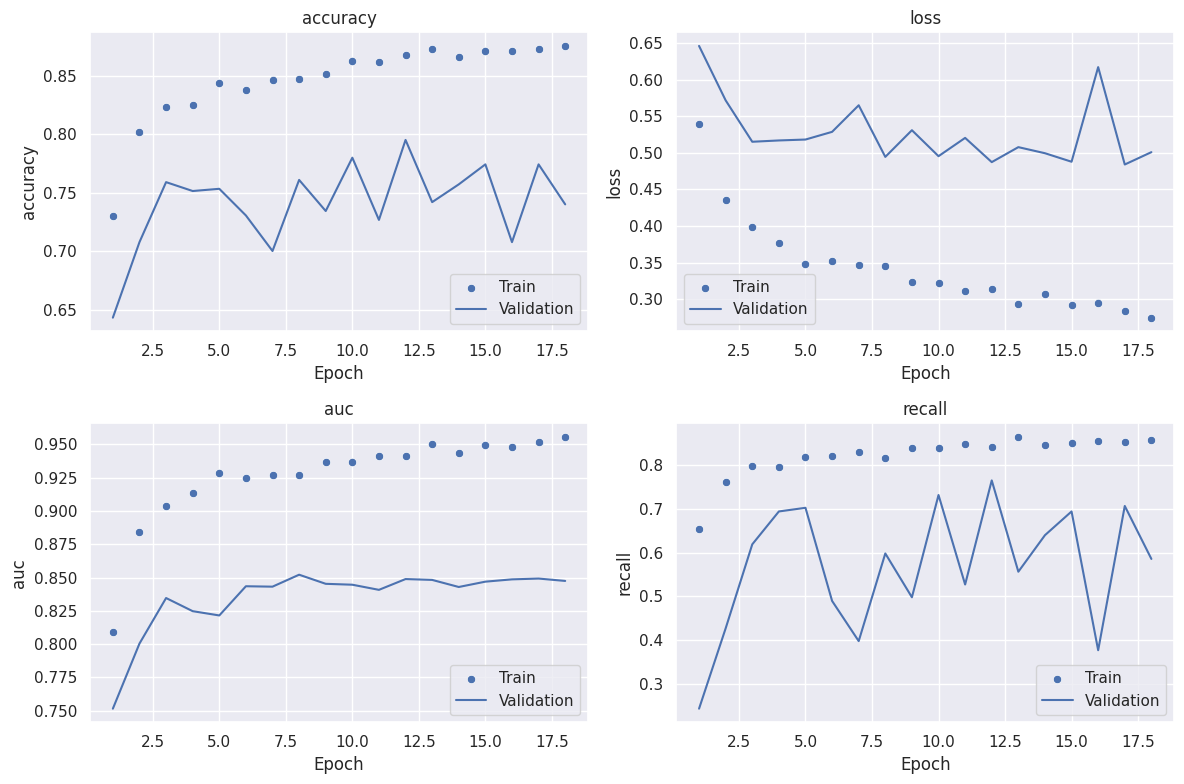

In [ ]:
def plot_training_history(metrics, hist_dict):
  epochs = range(1, len(hist_dict[metrics])+1)
  sns.scatterplot(x=epochs, y=hist_dict[metrics])
  sns.lineplot(x=epochs,y= hist_dict['val_'+metrics])
  plt.title(metrics)
  plt.xlabel('Epoch')
  plt.ylabel(metrics)
  plt.legend(['Train', 'Validation'])

def plot_4metrics(hist_dict):
  plt.figure(figsize=(12,8))
  metrics = ['accuracy', 'loss', 'auc', 'recall']
  for i, metric in enumerate(metrics):
    plt.subplot(2,2,i+1)
    plot_training_history(metric, hist_dict)
  plt.tight_layout()
  plt.show()

plot_4metrics(Xception_model_history.history)

In [ ]:
# Load modified Xception model
modified_Xception_model = keras.models.load_model(model_dir + '/' + 'Xception_model' + '.keras')

test_results = modified_Xception_model.evaluate(augmented_test_generator)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 548ms/step - accuracy: 0.8120 - auc: 0.8825 - fn: 38.5000 - fp: 30.3182 - loss: 0.4237 - precision: 0.7846 - recall: 0.7589 - tn: 176.2273 - tp: 120.4091


In [ ]:
def get_predictions_and_labels(model, generator):
  prediction_testset = []
  label_testset = []
  num_batch = len(generator)
  i = 0
  for data, label in generator:
    prediction_testset.extend(model.predict(data).flatten())
    label_testset.extend(label)
    i +=1
    if i >= num_batch:
      prediction_testset = np.array(prediction_testset)
      label_testset = np.array(label_testset)
      break
  return prediction_testset, label_testset

test_preds_xception, test_labels_xception = get_predictions_and_labels(modified_Xception_model, augmented_test_generator)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [ ]:
confustion_matrix = tf.math.confusion_matrix(labels=test_labels_xception, predictions=test_preds_xception>0.5)
confustion_matrix

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[306,  54],
       [ 77, 223]], dtype=int32)>

Text(46.25, 0.5, 'True class')

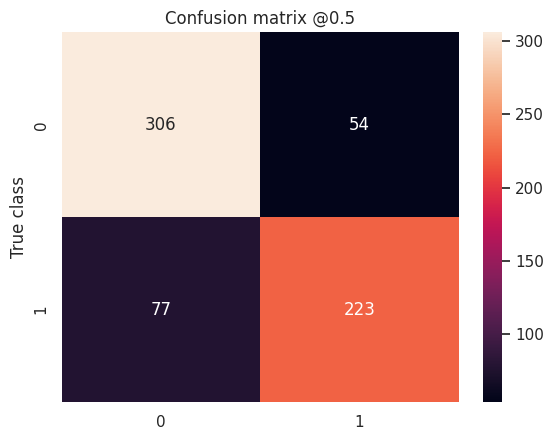

In [ ]:
## plot confusion matrix
sns.heatmap(confustion_matrix, annot=True, fmt='d')
plt.title('Confusion matrix @0.5')
plt.ylabel('True class')

In [ ]:
### Plot ROC and AUC
train_preds_xception, train_labels_xception = get_predictions_and_labels(modified_Xception_model, augmented_train_generator)
validation_preds_xception, validation_labels_xception = get_predictions_and_labels(modified_Xception_model, augmented_validation_generator)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━

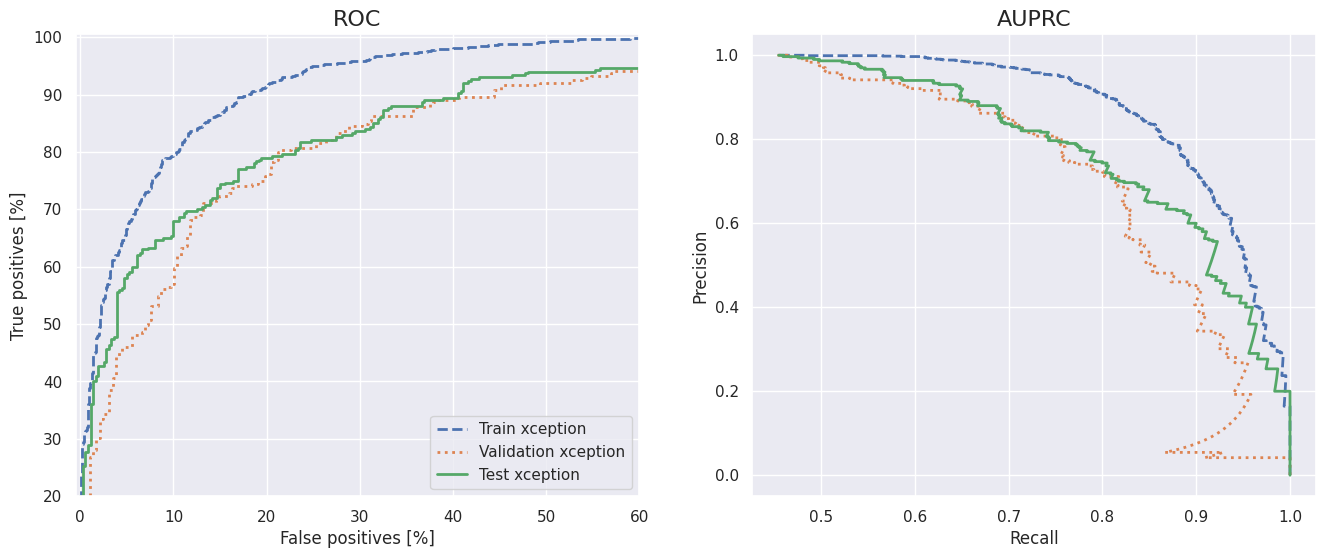

In [ ]:
# Plot the ROC and AUPRC
plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plot_roc('Train xception', train_labels_xception, train_preds_xception, linestyle='--')
plot_roc('Validation xception', validation_labels_xception, validation_preds_xception, linestyle=':')
plot_roc('Test xception', test_labels_xception, test_preds_xception)

plt.subplot(1, 2, 2)
plot_prc('Train xception', train_labels_xception, train_preds_xception, linestyle='--')
plot_prc('Validation xception', validation_labels_xception, validation_preds_xception, linestyle=':')
plot_prc('Test xception', test_labels_xception, test_preds_xception)

In [16]:
### Change the model by setting trainable layers in Xception

pre_trained_Xception.trainable = True

for layer in pre_trained_Xception.layers:
  if 'block14_' in layer.name:
    layer.trainable = True
  else:
    layer.trainable = False


input_tensor = keras.Input(shape=(image_size+(3,)), name='input')
x = pre_trained_Xception(input_tensor)
x = keras.layers.Flatten(name='flatten')(x)
x = keras.layers.Dense(16, activation='relu', kernel_initializer='he_normal')(x)
output = keras.layers.Dense(1, activation='sigmoid', name='output', bias_initializer=output_bias)(x)

fine_turned_xception_model = keras.Model(inputs=input_tensor, outputs=output, name='fine_turned_xception_model')
fine_turned_xception_model.summary()



Model: "fine_turned_xception_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xception (Functional)                │ (None, 7, 7, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │       1,605,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,467,145 (85.71 MB)

 Trainable params: 6,354,465 (24.24 MB)

 Non-trainable params: 16,112,680 (61.46 MB)

In [ ]:
### compile the model and train it
fine_turned_xception_model.compile(loss='binary_crossentropy',
                                   optimizer=keras.optimizers.Adam(learning_rate=2e-5),
                                   metrics=model_metrics,
                                   )

fine_turned_xception_model_history = fine_turned_xception_model.fit(augmented_train_generator,
                                                                    validation_data=augmented_validation_generator,
                                                                    callbacks=callbacks('fine_turned_xception_model'),
                                                                    epochs=50)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


66/66 ━━━━━━━━━━━━━━━━━━━━ 714s 11s/step - accuracy: 0.6329 - auc: 0.6858 - fn: 197.8209 - fp: 156.8060 - loss: 0.6233 - precision: 0.5986 - recall: 0.5711 - tn: 443.1045 - tp: 288.7164 - val_accuracy: 0.7287 - val_auc: 0.8147 - val_fn: 112.0000 - val_fp: 31.0000 - val_loss: 0.5475 - val_precision: 0.8038 - val_recall: 0.5314 - val_tn: 257.0000 - val_tp: 127.0000
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 725s 11s/step - accuracy: 0.7996 - auc: 0.8702 - fn: 112.6716 - fp: 98.5672 - loss: 0.4567 - precision: 0.7968 - recall: 0.7682 - tn: 484.2686 - tp: 391.9254 - val_accuracy: 0.7287 - val_auc: 0.8519 - val_fn: 126.0000 - val_fp: 17.0000 - val_loss: 0.5466 - val_precision: 0.8692 - val_recall: 0.4728 - val_tn: 271.0000 - val_tp: 113.0000
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 695s 10s/step - accuracy: 0.8259 - auc: 0.9170 - fn: 97.4328 - fp: 86.3284 - loss: 0.3690 - precision: 0.8200 - recall: 0.7896 - tn: 511.7015 - tp: 391.4328 - val_accuracy: 0.7306 - val_auc: 0.8698 - val_fn: 123.0000 - v

2